## Churn Prediction using Logisitic Regression

## Data Dictionary

There are multiple variables in the dataset which can be cleanly divided in 3 categories:

### Demographic information about customers

<b>customer_id</b> - Customer id

<b>vintage</b> - Vintage of the customer with the bank in number of days

<b>age</b> - Age of customer

<b>gender</b> - Gender of customer

<b>dependents</b> - Number of dependents

<b>occupation</b> - Occupation of the customer 

<b>city</b> - City of customer (anonymised)


### Customer Bank Relationship


<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)

<b>branch_code</b> - Branch Code for customer account

<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year


### Transactional Information

<b>current_balance</b> - Balance as of today

<b>previous_month_end_balance</b> - End of Month Balance of previous month


<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter

<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter

<b>current_month_credit</b> - Total Credit Amount current month

<b>previous_month_credit</b> - Total Credit Amount previous month

<b>current_month_debit</b> - Total Debit Amount current month

<b>previous_month_debit</b> - Total Debit Amount previous month

<b>current_month_balance</b> - Average Balance of current month

<b>previous_month_balance</b> - Average Balance of previous month

<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)

## Churn Prediction Steps


* Load Data & Packages for model building & preprocessing
* Preprocessing & Missing value imputation
* Select features on the basis of EDA Conclusions & build baseline model
* Decide Evaluation Metric on the basis of business problem
* Build model using all features & compare with baseline

### Loading Packages

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Loading Data

In [59]:
df = pd.read_csv('churn_prediction.csv')

### Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values  is a necessary step before we fit a model on the dataset.

In [60]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

The result of this function shows that there are quite a few missing values in columns gender, dependents, city, days since last transaction and Percentage change in credits. Let us go through each of them 1 by 1 to find the appropriate missing value imputation strategy for each of them.

#### Gender

L
et us look at the categories within gender column

In [61]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

So there is a good mix of males and females and arguably missing values cannot be filled with any one of them. We could create a seperate category by assigning the value -1 for all missing values in this column.

Before that, first we will convert the gender into 0/1 and then replace missing values with -1

In [62]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

#### Dependents, occupation and city with mode

Next we will have a quick look at the dependents & occupations column and impute with mode as this is sort of an ordinal variable

In [63]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [64]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [65]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

Similarly City can also be imputed with most common category 1020

In [66]:
df['city'] = df['city'].fillna(1020)

#### Days since Last Transaction
A fair assumption can be made on this column as this is number of days since last transaction in 1 year, we can substitute missing values with a value greater than 1 year say 999

In [67]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

### Preprocessing

Now, before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric strictly. 


### Dummies with Multiple Categories

In [68]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

### Scaling Numerical Features for Logistic Regression

Now, we remember that there are a lot of outliers in the dataset especially when it comes to previous and current balance features. Also, the distributions are skewed for these features. We will take 2 steps to deal with that here:
* Log Transformation
* Standard Scaler

Standard scaling is anyways a necessity when it comes to linear models and we have done that here after doing log transformation on all balance features.

In [69]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [70]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [71]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

## Model Building and Evaluation Metrics
Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Recall
2. Area under the Receiver operating characteristic curve

Now, we are looking at the recall value here because a customer falsely marked as churn would not be as bad as a customer who was not detected as a churning customer and appropriate measures were not taken by the bank to stop him/her from churning

The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (x-axis) and the false positive rate (y-axis).

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 2 classes.

### Conclusions from EDA
* For debit values, we see that there is a significant difference in the distribution for churn and non churn and it might be turn out to be an important feature
* For all the balance features the lower values have much higher proportion of churning customers
* For most frequent vintage values, the churning customers are slightly higher, while for higher values of vintage, we have mostly non churning customers which is in sync with the age variable 
* We see significant difference for different occupations and certainly would be interesting to use as a feature for prediction of churn.

Now, we will first split our dataset into test and train and using the above conclusions select columns and build a baseline logistic regression model to check the ROC-AUC Score & the confusion matrix

### Baseline Columns

In [72]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [73]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [74]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [75]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

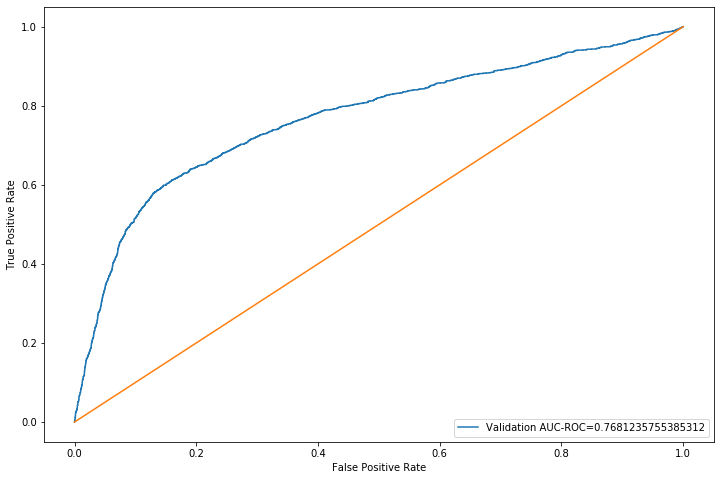

In [76]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [77]:
# Confusion Matrix
pred_val = model.predict(xtest)

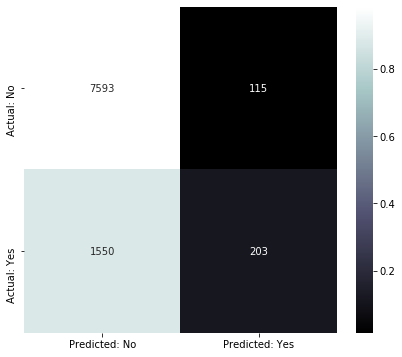

In [78]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [79]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

### Cross validation


Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

We divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

Since it builds several models on different subsets of the dataset, we can be more sure of our model performance if we use CV for testing our models.

In [80]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [81]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.7785366354948104, Recall Score: 0.0770, Precision Score: 0.6532 

3 of kfold 5
ROC AUC Score: 0.7552602062967885, Recall Score: 0.1350, Precision Score: 0.6425 

4 of kfold 5
ROC AUC Score: 0.758209770152749, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7653189015485415, Recall Score: 0.1131, Precision Score: 0.5640 


Now let us try using all columns available to check if we get significant improvement.

In [82]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7329374165039565, Recall Score: 0.1093, Precision Score: 0.5066 

2 of kfold 5
ROC AUC Score: 0.7680156201829207, Recall Score: 0.1968, Precision Score: 0.6809 

3 of kfold 5
ROC AUC Score: 0.7393130731380004, Recall Score: 0.1683, Precision Score: 0.5728 

4 of kfold 5
ROC AUC Score: 0.7328447133158789, Recall Score: 0.1207, Precision Score: 0.6019 

5 of kfold 5
ROC AUC Score: 0.758855886628863, Recall Score: 0.1730, Precision Score: 0.5987 


There is some improvement in both ROC AUC Scores and Precision/Recall Scores.

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rf_all_features = cv_score(RandomForestClassifier(n_estimators=100, max_depth=8))


1 of kfold 5
ROC AUC Score: 0.8202050149008324, Recall Score: 0.3432, Precision Score: 0.7337 

2 of kfold 5
ROC AUC Score: 0.8453757065049841, Recall Score: 0.3660, Precision Score: 0.7685 

3 of kfold 5
ROC AUC Score: 0.836426250213796, Recall Score: 0.3489, Precision Score: 0.7614 

4 of kfold 5
ROC AUC Score: 0.8302493931479995, Recall Score: 0.3650, Precision Score: 0.7427 

5 of kfold 5
ROC AUC Score: 0.8237452635941426, Recall Score: 0.3498, Precision Score: 0.7404 


## Comparison of Different model fold wise

Let us visualise the cross validation scores for each fold for the following 3 models and observe differences:
* Baseline Model
* Model based on all features
* Model based on top 10 features obtained from RFE

In [85]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'random_forest': rf_all_features})

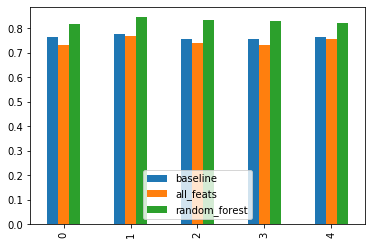

In [86]:
results_df.plot(y=["baseline", "all_feats", "random_forest"], kind="bar")

Here, we can see that the random forest model is giving the best result for each fold and students are encouraged to try and fine tune the model to get the best results.